In [1]:
import numpy as np
import sklearn
from sklearn import datasets, model_selection, metrics
import matplotlib.pyplot as plt
from collections import Counter

# Decision Tree


In [2]:
class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:

        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_counts)])
            return f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"




class DecisionTree():
    """
    Decision Tree Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(self, max_depth=4, min_samples_leaf=1,
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        """
        Setting the class with hyperparameters
        max_depth: (int) -> max depth of the tree
        min_samples_leaf: (int) -> min # of samples required to be in a leaf to make the splitting possible
        min_information_gain: (float) -> min information gain required to make the splitting possible
        num_of_features_splitting: (str) ->  when splitting if sqrt then sqrt(# of features) features considered,
                                                            if log then log(# of features) features considered
                                                            else all features are considered
        amount_of_say: (float) -> used for Adaboost algorithm
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p>0])

    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))

    def _partition_entropy(self, subsets: list) -> float:
        """subsets = list of label lists (EX: [[1,0,0], [1,1,1])"""
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])

    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:

        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2

    def _select_features_to_use(self, data: np.array) -> list:
        """
        Randomly selects the features to use while splitting w.r.t. hyperparameter numb_of_features_splitting
        """
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))))
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))))
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use

    def _find_best_split(self, data: np.array) -> tuple:
        """
        Finds the best split (with the lowest entropy) given data
        Returns 2 splitted groups and split information
        """
        min_part_entropy = 1e9
        feature_idx_to_use =  self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2, = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_label_probs(self, data: np.array) -> np.array:

        labels_as_integers = data[:,-1].astype(int)
        # Calculate the total number of labels
        total_labels = len(labels_as_integers)
        # Calculate the ratios (probabilities) for each label
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)

        # Populate the label_probabilities array based on the specific labels
        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == i)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:
        """
        Recursive, depth first tree creation algorithm
        """

        # Check if the max depth has been reached (stopping criteria)
        if current_depth > self.max_depth:
            return None

        # Find best split
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)

        # Find label probs for the node
        label_probabilities = self._find_label_probs(data)

        # Calculate information gain
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy

        # Create node
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        # Check if the min_samples_leaf has been satisfied (stopping criteria)
        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        # Check if the min_information_gain has been satisfied (stopping criteria)
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)

        return node

    def _predict_one_sample(self, X: np.array) -> np.array:
        """Returns prediction for 1 dim array"""
        node = self.tree

        # Finds the leaf which X belongs
        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """
        Trains the model with given X and Y datasets
        """

        # Concat features and labels
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        # Start creating the tree
        self.tree = self._create_tree(data=train_data, current_depth=0)

        # Calculate feature importance
        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        # Normalize the feature importance values
        self.feature_importances = {k: v / total for total in (sum(self.feature_importances.values()),) for k, v in self.feature_importances.items()}

    def predict_proba(self, X_set: np.array) -> np.array:
        """Returns the predicted probs for a given data set"""

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)

        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)

        return preds

    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        """Calculates the feature importance by visiting each node in the tree recursively"""
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)


# Random Forest Classifier

In [3]:
class RandomForestClassifier():
    """
    Random Forest Classifier
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    """

    def __init__(self, n_base_learner=10, max_depth=5, min_samples_leaf=1, min_information_gain=0.0, \
                 numb_of_features_splitting=None, bootstrap_sample_size=None) -> None:
        self.n_base_learner = n_base_learner
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.bootstrap_sample_size = bootstrap_sample_size

    def _create_bootstrap_samples(self, X, Y) -> tuple:
        """
        Creates bootstrap samples for each base learner
        """
        bootstrap_samples_X = []
        bootstrap_samples_Y = []

        for i in range(self.n_base_learner):

            if not self.bootstrap_sample_size:
                self.bootstrap_sample_size = X.shape[0]

            sampled_idx = np.random.choice(X.shape[0], size=self.bootstrap_sample_size, replace=True)
            bootstrap_samples_X.append(X[sampled_idx])
            bootstrap_samples_Y.append(Y[sampled_idx])

        return bootstrap_samples_X, bootstrap_samples_Y

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """Trains the model with given X and Y datasets"""
        bootstrap_samples_X, bootstrap_samples_Y = self._create_bootstrap_samples(X_train, Y_train)

        self.base_learner_list = []
        for base_learner_idx in range(self.n_base_learner):
            base_learner = DecisionTree(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, \
                                        min_information_gain=self.min_information_gain,
                                        numb_of_features_splitting=self.numb_of_features_splitting)

            base_learner.train(bootstrap_samples_X[base_learner_idx], bootstrap_samples_Y[base_learner_idx])
            self.base_learner_list.append(base_learner)

        # Calculate feature importance
        self.feature_importances = self._calculate_rf_feature_importance(self.base_learner_list)

    def _predict_proba_w_base_learners(self,  X_set: np.array) -> list:
        """
        Creates list of predictions for all base learners
        """
        pred_prob_list = []
        for base_learner in self.base_learner_list:
            pred_prob_list.append(base_learner.predict_proba(X_set))

        return pred_prob_list

    def predict_proba(self, X_set: np.array) -> list:
        """Returns the predicted probs for a given data set"""

        pred_probs = []
        base_learners_pred_probs = self._predict_proba_w_base_learners(X_set)

        # Average the predicted probabilities of base learners
        for obs in range(X_set.shape[0]):
            base_learner_probs_for_obs = [a[obs] for a in base_learners_pred_probs]
            # Calculate the average for each index
            obs_average_pred_probs = np.mean(base_learner_probs_for_obs, axis=0)
            pred_probs.append(obs_average_pred_probs)

        return pred_probs

    def predict(self, X_set: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)

        return preds

    def _calculate_rf_feature_importance(self, base_learners):
        """Calcalates the average feature importance of the base learners"""
        feature_importance_dict_list = []
        for base_learner in base_learners:
            feature_importance_dict_list.append(base_learner.feature_importances)

        feature_importance_list = [list(x.values()) for x in feature_importance_dict_list]
        average_feature_importance = np.mean(feature_importance_list, axis=0)

        return average_feature_importance

# Ada Boost Classifier

In [4]:
class AdaBoostClassifier():
    """
    AdaBoost Classifier Model
    Training: Use "train" function with train set features and labels
    Predicting: Use "predict" function with test set features
    The algorithm used in this class is SAMME algorithm with boosting with resampling
    """

    def __init__(self, n_base_learner=10) -> None:
        """
        Initialize the object with the hyperparameters
        n_base_learner: # of base learners in the model (base learners are DecisionTree with max_depth=1)
        """
        self.n_base_learner = n_base_learner

    def _calculate_amount_of_say(self, base_learner: DecisionTree, X: np.array, y: np.array) -> float:
        """calculates the amount of say (see SAMME)"""
        K = self.label_count
        preds = base_learner.predict(X)
        err = 1 - np.sum(preds==y) / preds.shape[0]
        amount_of_say = np.log((1-err)/err) + np.log(K-1)
        return amount_of_say

    def _fit_base_learner(self, X_bootstrapped: np.array, y_bootstrapped: np.array) -> DecisionTree:
        """Trains a Decision Tree model with depth 1 and returns the model"""
        base_learner = DecisionTree(max_depth=1)
        base_learner.train(X_bootstrapped, y_bootstrapped)
        base_learner.amount_of_say = self._calculate_amount_of_say(base_learner, self.X_train, self.y_train)

        return base_learner

    def _update_dataset(self, sample_weights: np.array) -> tuple:
        """Creates bootstrapped samples w.r.t. sample weights"""
        n_samples = self.X_train.shape[0]
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True, p=sample_weights)
        X_bootstrapped = self.X_train[bootstrap_indices]
        y_bootstrapped = self.y_train[bootstrap_indices]

        return X_bootstrapped, y_bootstrapped

    def _calculate_sample_weights(self, base_learner: DecisionTree) -> np.array:
        """Calculates sample weights (see SAMME)"""
        preds = base_learner.predict(self.X_train)
        matches = (preds == self.y_train)
        not_matches = (~matches).astype(int)
        sample_weights = 1/self.X_train.shape[0] * np.exp(base_learner.amount_of_say*not_matches)
        # Normalize weights
        sample_weights = sample_weights / np.sum(sample_weights)

        return sample_weights

    def train(self, X_train: np.array, y_train: np.array) -> None:
        """
        trains base learners with given feature and label dataset
        """
        self.X_train = X_train
        self.y_train = y_train
        X_bootstrapped = X_train
        y_bootstrapped = y_train
        self.label_count = len(np.unique(y_train))

        self.base_learner_list = []
        for i in range(self.n_base_learner):
            base_learner = self._fit_base_learner(X_bootstrapped, y_bootstrapped)
            self.base_learner_list.append(base_learner)
            sample_weights = self._calculate_sample_weights(base_learner)
            X_bootstrapped, y_bootstrapped = self._update_dataset(sample_weights)

    def _predict_scores_w_base_learners(self,  X: np.array) -> list:
        """
        Creates list of predictions for all base learners
        """
        pred_scores = np.zeros(shape=(self.n_base_learner, X.shape[0], self.label_count))
        for idx, base_learner in enumerate(self.base_learner_list):
            pred_probs = base_learner.predict_proba(X)
            pred_scores[idx] = pred_probs*base_learner.amount_of_say

        return pred_scores

    def predict_proba(self, X: np.array) -> np.array:
        """Returns the predicted probs for a given data set"""

        pred_probs = []
        base_learners_pred_scores = self._predict_scores_w_base_learners(X)

        # Take the avg scores and turn them to probabilities
        avg_base_learners_pred_scores = np.mean(base_learners_pred_scores, axis=0)
        column_sums = np.sum(avg_base_learners_pred_scores, axis=1)
        pred_probs = avg_base_learners_pred_scores / column_sums[:, np.newaxis]

        return pred_probs

    def predict(self, X: np.array) -> np.array:
        """Returns the predicted labels for a given data set"""

        pred_probs = self.predict_proba(X)
        preds = np.argmax(pred_probs, axis=1)

        return preds

In [5]:
iris = datasets.load_iris()

X = np.array(iris.data)
Y = np.array(iris.target)
iris_feature_names = iris.feature_names

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=0)
print("Train Shape:", X_train.shape)
print("Train Shape:", X_test.shape)
# Building random forest model
rf_model = RandomForestClassifier(n_base_learner=50, numb_of_features_splitting="sqrt")
rf_model.train(X_train, Y_train)
# Performans increases when compared to the basic DecisionTree
train_preds = rf_model.predict(X_set=X_train)
print("TRAIN PERFORMANCE")
print("Train size", len(Y_train))
print("True preds", sum(train_preds == Y_train))
print("Accuracy", sum(train_preds == Y_train) / len(Y_train))

test_preds = rf_model.predict(X_set=X_test)
print("TEST PERFORMANCE")
print("Test size", len(Y_test))
print("True preds", sum(test_preds == Y_test))
print("Accuracy", sum(test_preds == Y_test) / len(Y_test))

Train Shape: (112, 4)
Train Shape: (38, 4)
TRAIN PERFORMANCE
Train size 112
True preds 112
Accuracy 1.0
TEST PERFORMANCE
Test size 38
True preds 37
Accuracy 0.9736842105263158


In [6]:
iris = datasets.load_iris()

X = np.array(iris.data)
Y = np.array(iris.target)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)

model = AdaBoostClassifier(n_base_learner=50)
model.train(X_train, y_train)

train_accuracy = sum(model.predict(X=X_train) == y_train) / len(y_train)
test_accuracy = sum(model.predict(X=X_test) == y_test) / len(y_test)
print("Our Model Performance")
print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)
iris = datasets.load_iris()

X = np.array(iris.data)
Y = np.array(iris.target)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)

model = sklearn.ensemble.AdaBoostClassifier(n_estimators=50)
model.fit(X_train, y_train)

train_accuracy = sum(model.predict(X=X_train) == y_train) / len(y_train)
test_accuracy = sum(model.predict(X=X_test) == y_test) / len(y_test)
print("Sklearn Model Performance")
print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Our Model Performance
Train Accuracy:  0.9166666666666666
Test Accuracy:  0.9333333333333333
Sklearn Model Performance
Train Accuracy:  1.0
Test Accuracy:  0.9666666666666667


# k-Means Clustering

In [7]:
class K_Means:

    def __init__(self, k=2, tolerance = 0.001, max_iter = 500):
        self.k = k
        self.max_iterations = max_iter
        self.tolerance = tolerance

    def euclidean_distance(self, point1, point2):
        #return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)   #sqrt((x1-x2)^2 + (y1-y2)^2)
        return np.linalg.norm(point1-point2, axis=0)

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

    def fit(self, data):
        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i]


        for i in range(self.max_iterations):
            self.classes = {}
            for j in range(self.k):
                self.classes[j] = []

            for point in data:
                distances = []
                for index in self.centroids:
                    distances.append(self.euclidean_distance(point,self.centroids[index]))
                cluster_index = distances.index(min(distances))
                self.classes[cluster_index].append(point)

            previous = dict(self.centroids)
            for cluster_index in self.classes:
                self.centroids[cluster_index] = np.average(self.classes[cluster_index], axis = 0)



            isOptimal = True

            for centroid in self.centroids:
                original_centroid = previous[centroid]
                curr = self.centroids[centroid]
                if np.sum((curr - original_centroid)/original_centroid * 100.0) > self.tolerance:
                    isOptimal = False
            if isOptimal:
                break

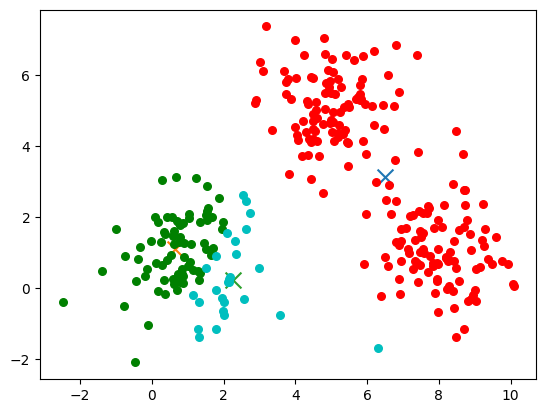

In [8]:
K=3
center_1 = np.array([1,1])
center_2 = np.array([5,5])
center_3 = np.array([8,1])

# Generate random data and center it to the three centers
cluster_1 = np.random.randn(100, 2) + center_1
cluster_2 = np.random.randn(100,2) + center_2
cluster_3 = np.random.randn(100,2) + center_3

data = np.concatenate((cluster_1, cluster_2, cluster_3), axis = 0)

k_means = K_Means(K)
k_means.fit(data)


# Plotting starts here
colors = 10*["r", "g", "c", "b", "k"]

for centroid in k_means.centroids:
    plt.scatter(k_means.centroids[centroid][0], k_means.centroids[centroid][1], s = 130, marker = "x")

for cluster_index in k_means.classes:
    color = colors[cluster_index]
    for features in k_means.classes[cluster_index]:
        plt.scatter(features[0], features[1], color = color,s = 30)